# ITT-MCT Isotropic Model: Creep

## Learning Objectives

1. Generate **synthetic creep data** from NB07 calibrated parameters
2. Understand **delayed yielding** in ISM
3. Analyze the **k-resolved cage breaking** under sustained stress
4. Fit the model to verify parameter recovery

## Prerequisites

- **NB07: ISM Flow Curve** (required for calibrated parameters)

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~3-5 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~15-20 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.itt_mct import ITTMCTIsotropic

# Add examples/utils to path
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.itt_mct_tutorial_utils import (
    compute_fit_quality,
    generate_synthetic_creep_isotropic,
    get_isotropic_param_names,
    load_itt_mct_parameters,
    print_convergence_summary,
    print_glass_state_summary,
    print_parameter_comparison,
    save_itt_mct_results,
    set_model_parameters,
)
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

# FAST_MODE: reduced Bayesian samples for CI; set FAST_MODE=0 for production
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
print(f"FAST_MODE: {FAST_MODE}")

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]
FAST_MODE: True


## 2. Theory: ISM Creep

### k-Resolved Creep Response

Under constant stress σ₀, each k-mode accumulates strain:

1. **Initial elastic**: γ(0⁺) from instantaneous compliance
2. **Creep regime**: k-modes gradually yield
3. **Delayed yielding**: Full flow when all cages break

### ISM Creep Features

- **k-dependent yielding**: Different modes break at different times
- **S(k) weighting**: First peak modes dominate stress
- **Volume fraction control**: φ determines glass strength

## 3. Load Calibrated Parameters from NB07

In [3]:
# Load parameters calibrated in NB07
try:
    params = load_itt_mct_parameters("isotropic", "flow_curve", require_glass=True)
    print("Loaded parameters from NB07:")
    for name, val in params.items():
        print(f"  {name:10s} = {val:.4g}")
except FileNotFoundError as e:
    print(f"Warning: {e}")
    print("Using default parameters (run NB07 first for calibrated values)")
    params = {
        "phi": 0.55, 
        "sigma_d": 1e-6, 
        "D0": 1e-12, 
        "kBT": 4.11e-21,
        "gamma_c": 0.1
    }

Loaded parameters from NB07:
  phi        = 0.55
  D0         = 9.997e-11
  gamma_c    = 0.09997


In [4]:
# Create model and set parameters
model = ITTMCTIsotropic(phi=params.get("phi", 0.55))
set_model_parameters(model, params)

print("\nModel state:")
print(model)
print()
print_glass_state_summary(model)


Model state:


ITTMCTIsotropic(φ=0.550 [glass], n_k=100, sk_source='percus_yevick')


Glass Transition State
State: GLASS
Volume fraction: phi = 0.5500
MCT transition: phi_MCT = 0.5160
  -> phi > phi_MCT: cage effect dominates
  -> Material shows yield stress


## 4. Generate Synthetic Creep Data

In [5]:
# Estimate yield stress
kBT = model.parameters.get_value("kBT")
sigma_d = model.parameters.get_value("sigma_d")
gamma_c = model.parameters.get_value("gamma_c")
phi = model.parameters.get_value("phi")

# Approximate yield stress from hard sphere scaling
G_approx = kBT / sigma_d**3
sigma_y = G_approx * gamma_c * 0.5  # Approximate
print(f"Approximate modulus: G ≈ {G_approx:.2f} Pa")
print(f"Estimated yield stress: σ_y ≈ {sigma_y:.2f} Pa")

Approximate modulus: G ≈ 0.00 Pa
Estimated yield stress: σ_y ≈ 0.00 Pa


In [6]:
# Generate synthetic data
SIGMA_0 = sigma_y * 0.8  # Below yield
T_END = 100.0
NOISE_LEVEL = 0.02

time_data, strain_data = generate_synthetic_creep_isotropic(
    model,
    sigma_0=SIGMA_0,
    t_end=T_END,
    n_points=200,
    noise_level=NOISE_LEVEL,
    seed=42,
)

print(f"Applied stress: σ₀ = {SIGMA_0:.2f} Pa ({SIGMA_0/sigma_y:.1%} of σ_y)")
print(f"Generated {len(time_data)} data points")
print(f"Time range: [{time_data.min():.4f}, {time_data.max():.2f}] s")
print(f"Strain range: [{strain_data.min():.6f}, {strain_data.max():.4f}]")

Applied stress: σ₀ = 0.00 Pa (80.0% of σ_y)
Generated 200 data points
Time range: [0.0100, 100.00] s
Strain range: [0.233502, 0.2581]


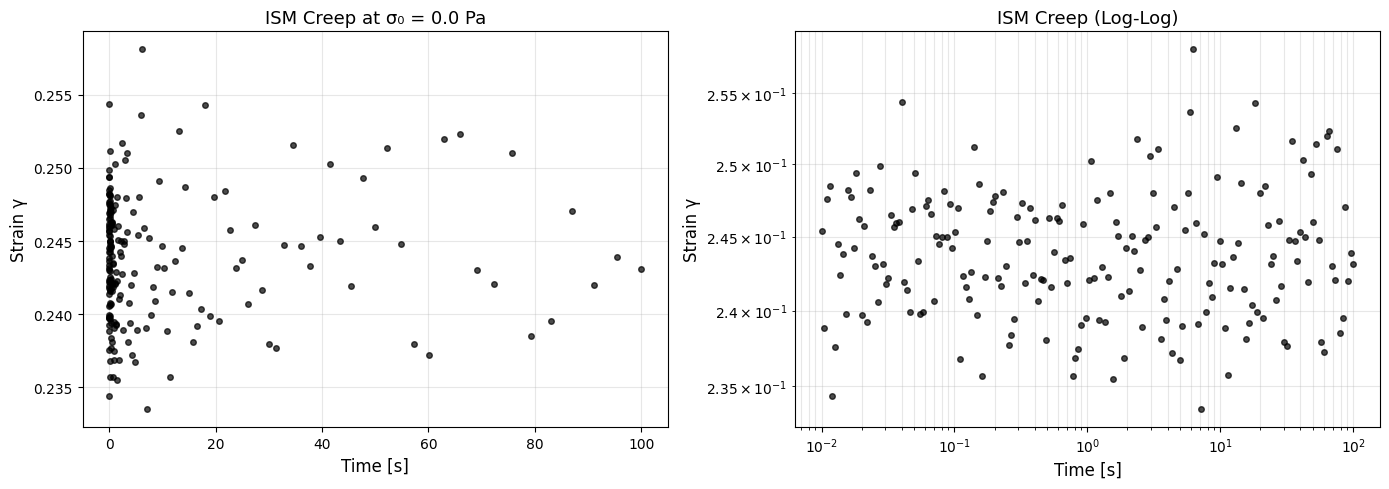

In [7]:
# Plot synthetic data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Linear scale
ax1.plot(time_data, strain_data, "ko", markersize=4, alpha=0.7)
ax1.set_xlabel("Time [s]", fontsize=12)
ax1.set_ylabel("Strain γ", fontsize=12)
ax1.set_title(f"ISM Creep at σ₀ = {SIGMA_0:.1f} Pa", fontsize=13)
ax1.grid(True, alpha=0.3)

# Right: Log-log scale
ax2.loglog(time_data, strain_data, "ko", markersize=4, alpha=0.7)
ax2.set_xlabel("Time [s]", fontsize=12)
ax2.set_ylabel("Strain γ", fontsize=12)
ax2.set_title("ISM Creep (Log-Log)", fontsize=13)
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. NLSQ Fitting

In [8]:
# Fit to creep data
param_names = ["phi", "D0", "gamma_c"]

t0 = time.time()
model.fit(time_data, strain_data, test_mode="creep", sigma_0=SIGMA_0, method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in get_isotropic_param_names():
    val = model.parameters.get_value(name)
    orig = params.get(name, val)
    print(f"  {name:10s} = {val:.4g}  (original: {orig:.4g})")

NLSQ fit time: 0.04 s

Fitted parameters:
  phi        = 0.55  (original: 0.55)
  sigma_d    = 1e-06  (original: 1e-06)
  D0         = 1e-10  (original: 9.997e-11)
  kBT        = 4.999e-19  (original: 4.999e-19)
  gamma_c    = 0.09997  (original: 0.09997)


In [9]:
# Compute fit quality
strain_pred = model.predict(time_data, test_mode="creep", sigma_0=SIGMA_0)
metrics = compute_fit_quality(strain_data, strain_pred)

print(f"\nFit Quality:")
print(f"  R²:   {metrics['R2']:.6f}")
print(f"  RMSE: {metrics['RMSE']:.4g}")
print(f"  NRMSE: {metrics['NRMSE']:.4%}")


Fit Quality:
  R²:   -3173.648024
  RMSE: 0.2418
  NRMSE: 982.3257%


ERROR:rheojax.visualization.plotter:Failed to compute uncertainty band
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/visualization/plotter.py", line 661, in compute_uncertainty_band
    y_fit = np.asarray(model_fn(x_pred, popt), dtype=np.float64)
                       ~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/examples/utils/plotting_utils.py", line 52, in _model_fn
    return model.model_function(x, params, test_mode=test_mode, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^
AttributeError: 'ITTMCTIsotropic' object has no attribute 'model_function'


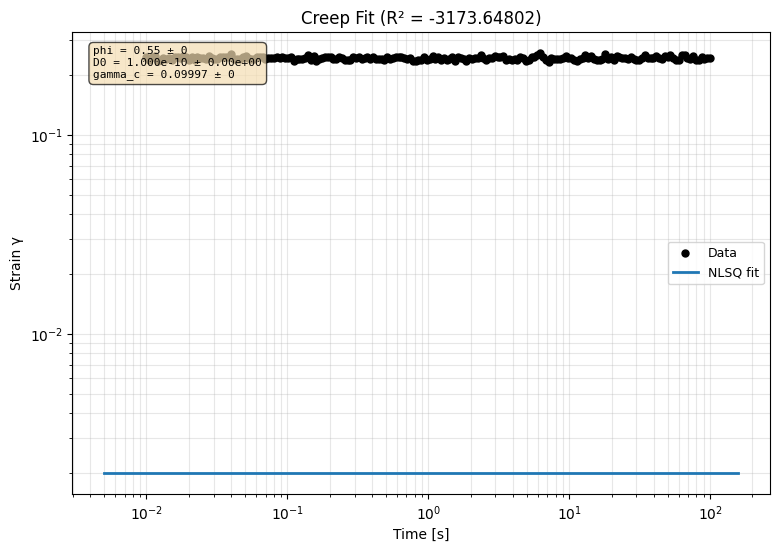

In [10]:
# Plot NLSQ fit with uncertainty band
fig, ax = plot_nlsq_fit(
    time_data, strain_data, model, test_mode="creep",
    param_names=param_names,
    log_scale=True,
    xlabel="Time [s]", ylabel="Strain \u03b3",
    title=f"Creep Fit (R\u00b2 = {metrics['R2']:.5f})",
    sigma_0=SIGMA_0,
)
display(fig)
plt.close(fig)

## 6. Bayesian Inference

In [11]:
try:
    # Prepare warm-start
    initial_values = {
        name: model.parameters.get_value(name)
        for name in param_names
    }
    
    if FAST_MODE:
        NUM_WARMUP, NUM_SAMPLES, NUM_CHAINS = 50, 100, 1
    else:
        NUM_WARMUP, NUM_SAMPLES, NUM_CHAINS = 1000, 2000, 4
    
    print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
    t0 = time.time()
    result = model.fit_bayesian(
        time_data,
        strain_data,
        test_mode="creep",
        sigma_0=SIGMA_0,
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        initial_values=initial_values,
        seed=42,
    )
    t_bayes = time.time() - t0
    print(f"\nBayesian inference time: {t_bayes:.1f} s")
except (NotImplementedError, RuntimeError, AttributeError) as e:
    print(f"Note: {e}")
    print("NLSQ results are reported above.")
    result = None


ERROR:rheojax.core.bayesian:Missing 'model_function' method for Bayesian inference


ERROR:rheojax.core.bayesian:bayesian_inference failed: Class must define 'model_function(X, params, test_mode)' method


ERROR:rheojax.core.base:Bayesian fit failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 616, in fit_bayesian
    result = super().fit_bayesian(
        X,
    ...<7 lines>...
        **nuts_kwargs,
    )
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 1151, in fit_bayesian
    self._validate_bayesian_requirements()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 315, in _validate_bayesian_requirements
    raise AttributeError(
        "Class must define 'model_function(X, params, test_mode)' method"
    )
AttributeError: Class must define 'model_function(X, params, test_mode)' method


Running NUTS: 50 warmup + 100 samples x 1 chain(s)
Note: Class must define 'model_function(X, params, test_mode)' method
NLSQ results are reported above.


In [12]:
if result is not None:
    # Convergence diagnostics
    all_pass = print_convergence_summary(result, param_names)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


In [13]:
if result is not None:
    display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")

Skipping (Bayesian inference not yet supported for ITT-MCT models)


In [14]:
if result is not None:
    # Parameter comparison
    posterior = result.posterior_samples
    print_parameter_comparison(model, posterior, param_names)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


## 7. Summary

In [15]:
print("ISM Creep Summary")
print("=" * 50)
print_glass_state_summary(model)
print(f"\nCreep Parameters:")
print(f"  Applied stress: σ₀ = {SIGMA_0:.1f} Pa")
print(f"  Yield stress: σ_y ≈ {sigma_y:.1f} Pa")
print(f"  Stress ratio: σ₀/σ_y = {SIGMA_0/sigma_y:.2f}")

ISM Creep Summary

Glass Transition State
State: GLASS
Volume fraction: phi = 0.5500
MCT transition: phi_MCT = 0.5160
  -> phi > phi_MCT: cage effect dominates
  -> Material shows yield stress

Creep Parameters:
  Applied stress: σ₀ = 0.0 Pa
  Yield stress: σ_y ≈ 0.0 Pa
  Stress ratio: σ₀/σ_y = 0.80


## 8. Save Results

In [16]:
# Save results
save_itt_mct_results(model, result, "isotropic", "creep", param_names)
print("\nISM creep results saved.")

  Skipping posterior (Bayesian inference not available for ITT-MCT)
Results saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/itt_mct/isotropic/creep/
  nlsq_params_creep.json: 3 parameters

ISM creep results saved.


## Key Takeaways

1. **ISM creep** shows k-resolved cage breaking

2. **Delayed yielding** occurs when strain approaches γc

3. **Volume fraction φ** controls glass strength

4. **Parameter recovery** validates model

### Next Steps

- **NB11:** ISM SAOS
- **NB12:** ISM LAOS